# Hugging Faceを使用したFine Tuning

参考としたコード
- Multilingual Sentiments Dataset
  - https://dev.classmethod.jp/articles/huggingface-jp-text-classification/
  - https://dev.classmethod.jp/articles/huggingface-usage-custom-model/
- 主観と客観の感情分析データセット
  - https://github.com/ghmagazine/llm-book/blob/main/chapter5/5-2-sentiment-analysis-finetuning-wrime.ipynb

In [1]:
import torch
# GPUが使用可能か判断
if torch.cuda.is_available():
    print('gpu is available')
else:
    raise Exception('gpu is NOT available')

gpu is available


In [2]:
import sys
# Goole Colab環境か判断
def is_colabo():
    moduleList = sys.modules
    if 'google.colab' in moduleList:
        return True
    else:
        return False

In [3]:
# 実行環境が Jupyter Notebook か否かをチェックする関数
# https://blog.amedama.jp/entry/detect-jupyter-env
def is_env_notebook():
    """Determine wheather is the environment Jupyter Notebook"""
    if 'get_ipython' not in globals():
        # Python shell
        return False
    env_name = get_ipython().__class__.__name__
    if env_name == 'TerminalInteractiveShell':
        # IPython shell
        return False
    # Jupyter Notebook
    return True

In [4]:
# 必要なライブラリのインストール
if is_colabo():
    !pip install transformers[torch] datasets

In [5]:
# 必要なライブラリのインストール
if is_colabo():
    !pip install fugashi
    !pip install ipadic
    !pip install sentencepiece

In [6]:
# エラー対策（ランタイムを再起動する必要がある）
if is_colabo():
    !pip install git+https://github.com/huggingface/accelerate
    !pip install --upgrade transformers

In [7]:
from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score
import torch
import random

In [8]:
# パターン選択

# Multilingual Sentiments Dataset
pattern1 = {
    'dataset_path': 'tyqiangz/multilingual-sentiments',
    'dataset_name': 'japanese',
    'text_column': 'text',  # トークナイズの対象列
    'save_dir': 'result/finetune_result1', # 結果を保存するフォルダ
}
# 主観と客観の感情分析データセット
pattern2 = {
    'dataset_path': 'llm-book/wrime-sentiment',
    'dataset_name': '',
    'text_column': 'sentence',
    'save_dir': 'result/finetune_result2' # 結果を保存するフォルダ
}

# どのパターンを使用するか決める
target_pattern = pattern2
print(target_pattern)

{'dataset_path': 'llm-book/wrime-sentiment', 'dataset_name': '', 'text_column': 'sentence', 'save_dir': 'result/finetune_result2'}


In [9]:
# データセットのロード
print(f"dataset :{target_pattern['dataset_path']}")
dataset = load_dataset(target_pattern['dataset_path'],
                       target_pattern['dataset_name'])

dataset :llm-book/wrime-sentiment


In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 20149
    })
    validation: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 1608
    })
    test: Dataset({
        features: ['sentence', 'label', 'user_id', 'datetime'],
        num_rows: 1781
    })
})

In [11]:
# 実験のためデータセットを縮小したい場合はコチラを有効化
random.seed(42)
dataset = DatasetDict({
    "train": dataset['train'].select(
        random.sample(range(dataset['train'].num_rows), k=500)),
    "validation": dataset['validation'].select(
        random.sample(range(dataset['validation'].num_rows), k=500)),
    "test": dataset['test'].select(
        random.sample(range(dataset['test'].num_rows), k=500)),
})

In [12]:
# トークナイザのロード
model_ckpt = "cl-tohoku/bert-base-japanese-whole-word-masking"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

100%|██████████| 500/500 [00:00<00:00, 10092.26it/s]


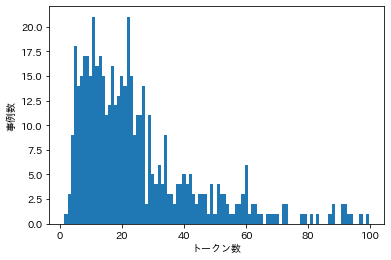

max: 99
95%: 91.95


100%|██████████| 500/500 [00:00<00:00, 8767.47it/s]


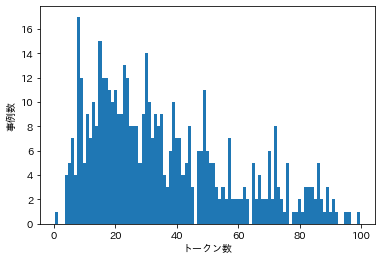

max: 99
95%: 90.55


In [13]:
# 大規模言語モデル入門に記載されているコードで視覚化して検証
from collections import Counter
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset
from tqdm import tqdm

# plt.rcParams["font.size"] = 18  # 文字サイズを大きくする

def visualize_text_length(dataset: Dataset):
    """データセット中のテキストのトークン数の分布をグラフとして描画"""
    # データセット中のテキストの長さを数える
    length_counter = Counter()
    for data in tqdm(dataset):
        length = len(tokenizer.tokenize(data["sentence"]))
        length_counter[length] += 1
    # length_counterの値から棒グラフを描画する
    if is_env_notebook():
        plt.bar(length_counter.keys(), length_counter.values(), width=1.0)
        plt.xlabel("トークン数")
        plt.ylabel("事例数")
        plt.show()
    print('max:',max(length_counter.keys()))
    PERCENT=95
    print(f'{PERCENT}%:',np.percentile([k for k in length_counter.keys()], PERCENT))

visualize_text_length(dataset['train'])
visualize_text_length(dataset['validation'])

トークナイズするときの最大長は100とする

In [14]:
# トークナイズ処理
def tokenize(batch):
    return tokenizer(batch[target_pattern['text_column']], padding=True, truncation=True, max_length=100)
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [15]:
# 事前学習モデルのロード
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = len(set(dataset['train']['label']))
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
        #  .to(device)
)

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# メトリクスの定義
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [17]:
import matplotlib.pyplot as plt

def show_graph(df, suptitle, regression, output='output.png'):
    suptitle_size = 23
    graph_title_size = 20
    legend_size = 18
    ticks_size = 13
    # 学習曲線
    fig = plt.figure(figsize=(20, 5))
    # plt.suptitle(','.join([f'{e}: {parameters[e]}' for e in parameters.keys()]), fontsize=suptitle_size)
    plt.suptitle(suptitle, fontsize=suptitle_size)
    # Train Loss
    plt.subplot(131)
    plt.title('Train Loss', fontsize=graph_title_size)
    plt.plot(df['loss'].dropna(), label='train')
    plt.legend(fontsize=legend_size)
    plt.yticks(fontsize=ticks_size)
    # Validation Loss
    plt.subplot(132)
    reg_str = f'$y={round(regression.coef_[0],5)}*x+{round(regression.intercept_,3)}$'
    plt.title(f'Val Loss', fontsize=graph_title_size)
    y = df['eval_loss'].dropna().values
    x = np.arange(len(y)).reshape(-1, 1)
    pred = regression.coef_ * x.ravel() + regression.intercept_  # 線形回帰直線
    plt.plot(y, color='tab:orange', label='val')
    plt.plot(pred, color='green', label='pred')
    plt.legend(fontsize=legend_size)
    plt.xlabel(reg_str, fontsize=ticks_size)
    plt.yticks(fontsize=ticks_size)
    # Accuracy/F1
    plt.subplot(133)
    plt.title('Accuracy/F1', fontsize=graph_title_size)
    plt.plot(df['eval_accuracy'].dropna(), label='accuracy')
    plt.plot(df['eval_f1'].dropna(), label='F1')
    plt.legend(fontsize=legend_size)
    plt.yticks(fontsize=ticks_size)
    plt.tight_layout()
    plt.show()
    plt.savefig(output)

チューニング対象
- type: constant, linear, cosine
- lr: 5e-6, 7.5e-6, 1e-5, 1.25e-5, 1.5e-5, 1.75e-5, 2e-5
- batch size: 16, 32, 64, 128, 256

In [18]:
# type: constant
# lr: 5e-6, 7.5e-6, 1e-5, 1.25e-5, 1.5e-5, 1.75e-5, 2e-5
# batch size: 16, 32, 64, 128, 256
hyper_parameters = [
    # {'epoch': 2, 'type': 'constant', 'lr': 5.0e-6, 'batch': 16},
    # {'epoch': 2, 'type': 'constant', 'lr': 5.0e-6, 'batch': 32},
    # {'epoch': 2, 'type': 'constant', 'lr': 5.0e-6, 'batch': 64},
    # {'epoch': 2, 'type': 'constant', 'lr': 5.0e-6, 'batch': 128},
    {'epoch': 20, 'type': 'constant', 'lr': 5.0e-6, 'batch': 256},
    # {'epoch': 2, 'type': 'constant', 'lr': 7.5e-6, 'batch': 16},
    # {'epoch': 2, 'type': 'constant', 'lr': 7.5e-6, 'batch': 32},
    # {'epoch': 2, 'type': 'constant', 'lr': 7.5e-6, 'batch': 64},
    # {'epoch': 2, 'type': 'constant', 'lr': 7.5e-6, 'batch': 128},
    # {'epoch': 2, 'type': 'constant', 'lr': 7.5e-6, 'batch': 256},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.0e-5, 'batch': 16},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.0e-5, 'batch': 32},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.0e-5, 'batch': 64},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.0e-5, 'batch': 128},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.0e-5, 'batch': 256},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.25e-5, 'batch': 16},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.25e-5, 'batch': 32},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.25e-5, 'batch': 64},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.25e-5, 'batch': 128},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.25e-5, 'batch': 256},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.5e-5, 'batch': 16},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.5e-5, 'batch': 32},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.5e-5, 'batch': 64},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.5e-5, 'batch': 128},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.5e-5, 'batch': 256},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.75e-5, 'batch': 16},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.75e-5, 'batch': 32},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.75e-5, 'batch': 64},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.75e-5, 'batch': 128},
    # {'epoch': 2, 'type': 'constant', 'lr': 1.75e-5, 'batch': 256},
    # {'epoch': 2, 'type': 'constant', 'lr': 2.0e-5, 'batch': 16},
    # {'epoch': 2, 'type': 'constant', 'lr': 2.0e-5, 'batch': 32},
    # {'epoch': 2, 'type': 'constant', 'lr': 2.0e-5, 'batch': 64},
    # {'epoch': 2, 'type': 'constant', 'lr': 2.0e-5, 'batch': 128},
    # {'epoch': 2, 'type': 'constant', 'lr': 2.0e-5, 'batch': 256},
]

In [19]:
def get_train_arg(output_dir, hyper_parameter, epoch_num = 2):
    args = TrainingArguments(
        output_dir=output_dir,    # 結果の保存フォルダ
        # label_names=['label'],  # ラベルの名前
        num_train_epochs=epoch_num,      # エポック数
        learning_rate=hyper_parameter['lr'],       # 学習率
        per_device_train_batch_size=hyper_parameter['batch'], # 訓練時のバッチサイズ
        per_device_eval_batch_size=hyper_parameter['batch'],  # 評価時のバッチサイズ
        weight_decay=0.01,            # 正則化
        disable_tqdm=False,           # プログレスバー非表示
        logging_strategy="epoch",     # ロギングのタイミング
        logging_steps=hyper_parameter['batch'], # ロギングのタイミング [0,1)
        evaluation_strategy="epoch",  # 検証セットによる評価のタイミング
        save_strategy="epoch",        # チェックポイントの保存タイミング
        push_to_hub=False,            # Huggin Haceにpushしない
        load_best_model_at_end=True,  # 訓練後に開発セットで最良のモデルをロード
        metric_for_best_model="accuracy",  # 最良のモデルを決定する評価指標
        log_level="error",            # ログレベル
        fp16=True,                    # 自動混合精度演算の有効化
        lr_scheduler_type=hyper_parameter['type'], # "constant", "linear", "cosine"
    )
    return args

In [20]:
from sklearn.linear_model import LinearRegression

def linear_regression(history_df):
    y = history_df['eval_loss'].dropna().values
    x = np.arange(len(y)).reshape(-1, 1)
    linear = LinearRegression().fit(x, y)
    return linear

In [21]:
from datetime import datetime, timedelta, timezone

def result_filename():
    JST = timezone(timedelta(hours=+9), 'JST')
    filename = f"result/result_{datetime.now(JST).strftime('%Y%m%d_%H%M%S')}.csv"
    return filename

In [22]:
from datetime import datetime, timedelta, timezone

def result_dirname():
    JST = timezone(timedelta(hours=+9), 'JST')
    dirname = f"result/result_{datetime.now(JST).strftime('%Y%m%d_%H%M%S')}"
    return dirname

In [23]:
import os
dir_name = result_dirname()
os.makedirs(dir_name)

0 {'epoch': 20, 'type': 'constant', 'lr': 5e-06, 'batch': 256}


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.691800,0.687166,0.544000,0.512097
2,0.684700,0.680235,0.600000,0.585374
3,0.685700,0.673521,0.624000,0.613101
4,0.672900,0.666689,0.654000,0.646479
5,0.665300,0.659702,0.672000,0.665831
6,0.649500,0.652556,0.692000,0.685854
7,0.643300,0.644846,0.708000,0.701473
8,0.633600,0.636536,0.730000,0.725929
9,0.622900,0.627518,0.736000,0.731611
10,0.608800,0.617915,0.748000,0.743260


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.w

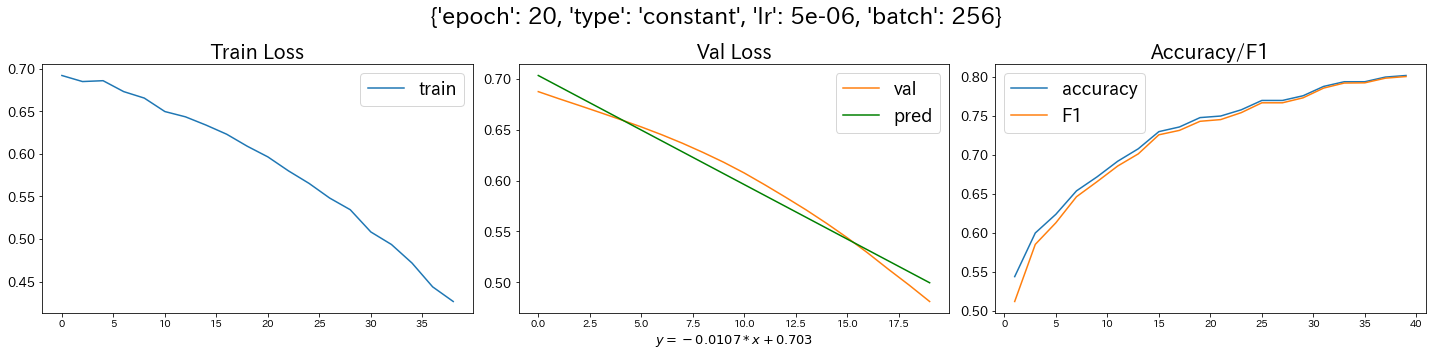

<Figure size 432x288 with 0 Axes>

In [24]:
import pandas as pd
from transformers import EarlyStoppingCallback

model_name = target_pattern['save_dir']

for idx, target in enumerate(hyper_parameters):
    hyper_parameter = hyper_parameters[idx]
    print(idx, hyper_parameter)

    # 訓練用の設定
    training_args = get_train_arg(model_name, hyper_parameter, epoch_num=hyper_parameter['epoch'])
    # Trainerの定義
    trainer = Trainer(
        model=model,                                # モデル
        args=training_args,                         # 学習パラメータ
        compute_metrics=compute_metrics,            # メトリクス
        train_dataset=dataset_encoded["train"],     # 訓練データ
        eval_dataset=dataset_encoded["validation"], # 検証データ
        tokenizer=tokenizer,                        # トークナイザ
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    # トレーニング実行
    trainer.train()

    # ログ
    history_df = pd.DataFrame(trainer.state.log_history)

    # 線形回帰
    reg = linear_regression(history_df)

    # 結果を表示
    show_graph(history_df, hyper_parameter, reg, f'{dir_name}/output{idx+1}.png')

    # ログ追加
    hyper_parameter['train_loss'] = history_df['loss'].dropna().values
    hyper_parameter['val_loss'] = history_df['eval_loss'].dropna().values
    hyper_parameter['coef'] = 1 if reg.coef_[0] > 0 else -1

    # break

In [25]:
# 結果を保存
result_df = pd.DataFrame(hyper_parameters)
filename = f"{dir_name}/result.csv"
result_df.to_csv(filename)
print(f"save file: {filename}")

save file: result/result_20230915_073148/result.csv


In [26]:
# CSV読み取り確認
pd.read_csv(filename, index_col=0)

,epoch,type,lr,batch,train_loss,val_loss,coef
0,20,constant,0.000005,256,[0.6918 0.6847 0.6857 0.6729 0.6653 0.6495 0.6...,[0.68716604 0.68023533 0.67352051 0.6666885 0...,-1
